In [1]:
import networkx as nx
import numpy as np
import os.path as op
import scipy as sp

import os
import csv

from copy import deepcopy
from collections import OrderedDict
from sklearn.preprocessing import normalize
from sklearn.neighbors import DistanceMetric
from scipy.linalg import svd
from scipy.linalg import norm

np.random.seed(12345678)  # for reproducibility, set random seed

In [11]:
path = '/Users/gkiar/code/ocp/ndmg-paper/data/cloud/'

# All
# dsets = ['BNU1', 'BNU3', 'HNU1', 'KKI2009', 'MRN1313', 'NKI1', 'NKIENH', 'SWU4', 'Templeton114', 'Templeton255']

# Sans Philips Scanner
# dsets = ['BNU1', 'BNU3', 'HNU1', 'MRN1313', 'NKI1', 'NKIENH', 'SWU4', 'Templeton114', 'Templeton255']

# Sans Philips and GE Scanners
dsets = ['BNU1', 'BNU3', 'MRN1313', 'NKI1', 'NKIENH', 'SWU4', 'Templeton114', 'Templeton255']


dir_names = [path + '/' + d for d in dsets]

N = 70

fs = OrderedDict()
for idx, dd in enumerate(dsets):
    fs[dd] = [root + "/" + fl for root, dirs, files in os.walk(dir_names[idx])
              for fl in files if fl.endswith(".gpickle") and "ses-1_" in fl]

ps = {os.path.splitext(os.path.basename(fl))[0] : root + "/" + fl
      for root, dirs, files in os.walk(path+'phenotypes')
      for fl in files if fl.endswith(".csv") }

print "Datasets: " + ", ".join([fkey + ' (' + str(len(fs[fkey])) + ')'
                                for fkey in fs])
S = sum([len(fs[key]) for key in fs])
print "Total Subjects: %d" % (S)

Datasets: BNU1 (57), BNU3 (47), MRN1313 (1299), NKI1 (20), NKIENH (198), SWU4 (227), Templeton114 (114), Templeton255 (253)
Total Subjects: 2215


In [12]:
def loadGraphs(filenames, verb=False):
    """
    Given a list of files, returns a dictionary of graphs

    Required parameters:
        filenames:
            - List of filenames for graphs
    Optional parameters:
        verb:
            - Toggles verbose output statements
    """
    #  Initializes empty dictionary
    gstruct = OrderedDict()
    for idx, files in enumerate(filenames):
        if verb:
            print "Loading: " + files
        #  Adds graphs to dictionary with key being filename
        fname = os.path.basename(files)
        gstruct[fname] = nx.read_gpickle(files)
    return gstruct

def constructGraphDict(names, fs, verb=False):
    """
    Given a set of files and a directory to put things, loads graphs.

    Required parameters:
        names:
            - List of names of the datasets
        fs:
            - Dictionary of lists of files in each dataset
    Optional parameters:
        verb:
            - Toggles verbose output statements
    """
    #  Loads graphs into memory for all datasets
    graphs = OrderedDict()
    for idx, name in enumerate(names):
        if verb:
            print "Loading Dataset: " + name
        # The key for the dictionary of graphs is the dataset name
        graphs[name] = loadGraphs(fs[name], verb=verb)
    return graphs

def rdf(dist, ids):
    N = dist.shape[0]
    assert(N == len(ids))
    uniqids = list(set(ids))
    countvec = [ids.count(uniqid) for uniqid in uniqids]
    scans = np.max(countvec)
    rdf = []

    for i in np.arange(0, N):
        ind = [idx for idx, x in enumerate(ids) if x == ids[i]]
        for j in ind:
            if i != j:
                di = deepcopy(dist[i,:])
                di[ind] = np.inf
                d = dist[i,j]
                diff = di[np.where(~np.isinf(di))]
                rdf += [1.0 - ((np.sum(diff < d) + 0.5*np.sum(diff == d)) / (1.0*(N-len(ind))))]
    return rdf

def partial_disc(D, labels, subject, trial1, trial2):
    enum = np.arange(D.shape[0])
    idx1 = [i for i, x in enumerate(labels) if x == subject]
    t1 = enum[idx1][trial1]
    t2 = enum[idx1][trial2]
    d_t1_t2 = D[t1][t2]
    
    idx2 = [i for i, x in enumerate(labels) if x != subject]
    d_ra = [D[t1][x] for x in enum[idx2]]
    
    return np.mean(d_t1_t2 < d_ra)

def distance_matrix(data, metric, symmetric = True):
    n = data.shape[2]
    dist_matrix = np.zeros((n, n))
    if symmetric:
        for i in range(n):
            for j in range(i):
                tmp = metric(data[:,:,i] - data[:,:,j])
                dist_matrix[i][j] = tmp
                dist_matrix[j][i] = tmp
    else:
        for i in range(n):
            for j in range(n):
                dist_matrix[i][j] = metric(data[i] - data[j])
    return dist_matrix

def discriminibility(data, labels, metric):
    dist_matrix = distance_matrix(data, metric)
    partials = []
    for s in list(set(labels)):
        num = ids.count(s)
        for t in range(num):
            for tt in range(num):
                if tt != t:
                    p = partial_disc(dist_matrix, labels, s, t, tt)
                    partials.append(p)
    return dist_matrix, np.mean(partials)

In [13]:
graphs = constructGraphDict(dsets, fs, verb=False)

## All subjs, ID = dset id

In [14]:
mat = np.zeros((N, N, S))
ids = []
c = 0

for dset in graphs.keys():
    for subj in graphs[dset].keys():
#         ids += [subj.split("_")[1]]
        ids += [dset]
        
        tmpg = np.array(nx.adj_matrix(graphs[dset][subj]).todense())
        ratio = np.sum(tmpg > 0)*1.0 / N / N
        mat[:, :, c] = tmpg
        c += 1
    
print "Shape after minor pruning: ", mat.shape, len(ids)

Shape after minor pruning:  (70, 70, 2215) 2215


In [15]:
mat.shape

(70, 70, 2215)

In [16]:
dist = distance_matrix(mat, norm)

In [17]:
dist.shape

(2215, 2215)

In [18]:
%%time
rdfs = rdf(dist, ids)
disc = np.mean(rdfs)
print disc
%time

0.626814749731
CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs
CPU times: user 3min 26s, sys: 1.4 s, total: 3min 27s
Wall time: 3min 32s


In [19]:
# np.savez(path+'distance_matrix_2266.npz', distance=dist, discriminability=disc, ids=ids)
# np.savez(path+'distance_matrix_2245.npz', distance=dist, discriminability=disc, ids=ids)
np.savez(path+'distance_matrix_2215.npz', distance=dist, discriminability=disc, ids=ids)

In [108]:
def permutation_test(disc, dist, ids, n=100):
    tests = []
    for i in np.arange(n):
        np.random.shuffle(ids)
        tmp_rdf = rdf(dist, ids)
        tmp_disc = np.mean(tmp_rdf)
        tests += [tmp_disc]
    p = np.sum(tests > disc)/1.0/n
    return tests, p

tests, p = permutation_test(disc, dist, ids, n=100)
print p

0.0


In [10]:
np.savez(path+'distance_matrix_2266.npz', distance=dist, discriminability=disc, ids=ids)

NameError: name 'disc' is not defined

In [134]:
fil = np.load(path+'distance_matrix_2266.npz')
dist = fil['distance']
disc = fil['discriminability']
ids = ids

In [136]:
f = open('disc_by_dset_ids.csv', 'wb')
f.write("\n".join([i for i in ids]))
f.close()
# np.savetxt('ids_all.csv', ids, delimiter=",")

In [20]:
np.savetxt("disc_by_dset_dists.csv", dist, delimiter=",")

In [135]:
disc, dist.shape

(array(0.6319533644972694), (2266, 2266))

In [17]:
import ndmg.stats.plotly_helper as plh
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
from plotly.graph_objs import *

sizes = [len(graphs[dset].keys()) for dset in graphs.keys()]
cumul = [0] + [np.sum(sizes[:i+1])-1 for i in range(len(sizes))]
ticks = [np.mean((cumul[idx], cumul[idx+1])) for idx in range(len(cumul)-1)]
ticks = [[tick-S/110.0, tick+S/110.0] for tick in ticks]
ticks = np.array([t for tick in ticks for t in tick])
ticks[4:6] -= S*0.01
ticks[6:8] += S*0.01
ticks[18:20] -= S*0.01

init_notebook_mode()
logdist = np.log10(dist)
locs = logdist == np.double('-inf')
logdist[locs] = None

diag = np.reshape(np.repeat(None, dist.shape[0]*dist.shape[1]), dist.shape)
diag[locs] = 1

# myplot = plh.plot_heatmap(logdist)

data = [Heatmap(z=logdist,
                showscale=True,
                colorscale='Viridis',
                colorbar=dict(tickvals=[5], ticktext=[''],
                              ypad=70)
               )]
myplot = Figure(data=data)

diagonal = {
  "z": diag,
  "colorscale": [ [0, "darkblue"], [1, "darkblue"] ], 
  "showscale": False, 
  "type": "heatmap", 
  "zmax": 1.5, 
  "zmin": 0.5
}
myplot.data += [diagonal]

def add_box(start, stop):
    box = [Scatter(
            x=[start, start],
            y=[start, stop],
            mode="lines",
            line=Line(color="#28282e", width=2),
            showlegend=False),
           Scatter(
            x=[stop, stop],
            y=[start, stop],
            mode="lines",
            line=Line(color="#28282e", width=2),
            showlegend=False),
           Scatter(
            x=[start, stop],
            y=[start, start],
            mode="lines",
            line=Line(color="#28282e", width=2),
            showlegend=False),
           Scatter(
            x=[start, stop],
            y=[stop, stop],
            mode="lines",
            line=Line(color="#28282e", width=2),
            showlegend=False)
          ]
    return box
    
# myplot.layout.title = "Multi-Study Distance Plot Using Desikan Atlas\nDiscriminability: {}".format(disc)
myplot.layout.width = 1000
myplot.layout.height = 1000
myplot.layout.yaxis.autorange = 'reversed'
myplot.layout.yaxis.tickvals = ticks
myplot.layout.xaxis.tickvals = [] #cumul
myplot.layout.yaxis.ticktext = [graphs.keys()[idx/2]
                                if idx % 2 == 0 else "(N={})".format(len(graphs.values()[(idx-1)/2]))
                                for idx, name in enumerate(ticks)]
myplot.layout.xaxis.ticktext = [] #['' for i in range(len(cumul))]
myplot.layout.yaxis.tickfont = dict(size=14, color='#28282e')
myplot.layout.yaxis.ticklen = 0 #15
myplot.layout.xaxis.ticklen = 0 #15
myplot.layout.yaxis.tickwidth = 0 #3
myplot.layout.xaxis.tickwidth = 0 #3

anno = [dict(x=0.5, y=1.01, xref='paper', yref='paper',
             text="Multi-Study Distance Plot Using Desikan Atlas",
             showarrow=False, font=dict(color="#28282e", size=18)),
        dict(x=0.5, y=0.985, xref='paper', yref='paper',
             text="N=%d, MNR=%.4f" % (S, disc),
             showarrow=False, font=dict(color="#28282e", size=18))]
boxes = []
for idx in range(len(cumul)-1):
    start, stop = cumul[idx], cumul[idx+1]
    lent = stop - start + 1
    if idx == len(cumul)-2:
        stop -= 0.5
    elif idx == 0:
        start -= 0.5
    boxes += add_box(start+0.5, stop+0.5)
myplot.data += boxes
myplot.layout.annotations = anno

# iplot(myplot)
plot(myplot, validate=False, filename='/Users/gkiar/code/ocp/ndmg-paper/code/discriminability/discriminability_full.html')

'file:///Users/gkiar/code/ocp/ndmg-paper/code/discriminability/discriminability_full.html'

# subset of subjs, id is dset

In [6]:
subN = 20
D = len(dsets)
mat = np.zeros((N, N, D*subN))
ids = []
c = 0
import random
random.seed(12334567890)

for dset in graphs.keys():
    subset = random.sample(range(len(graphs[dset].keys())), k=subN)
    for idx in subset:
        ids += [dset]
        tmpg = np.array(nx.adj_matrix(graphs[dset].values()[idx]).todense())
        ratio = np.sum(tmpg > 0)*1.0 / N / N
        mat[:, :, c] = tmpg
        c += 1
print "Shape after minor pruning: ", mat.shape, len(ids)

Shape after minor pruning:  (70, 70, 200) 200


In [114]:
dist = distance_matrix(mat, norm)
tmp_rdf = rdf(dist, ids)
disc = np.mean(tmp_rdf)
print disc

0.708257309942


In [115]:
np.savez(path+'distance_matrix_dsets{}.npz'.format(subN), distance=dist, ids=ids)

In [7]:
subN = 20
dat = np.load(path+'distance_matrix_dsets{}.npz'.format(20))
dist = dat['distance']
ids = dat['ids']

In [8]:
dist.shape

(200, 200)

[0, 56, 103, 133, 154, 1453, 1473, 1671, 1898, 2012, 2265]


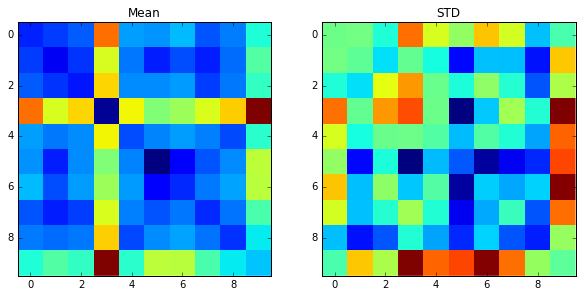

5.00580701536 5.37657507423
4.43053347888 4.68218711682
4.76297889631 5.58924975082
4.43053347888 5.58924975082


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:36: RuntimeWarning: divide by zero encountered in log10


In [9]:
fil = np.load(path+'distance_matrix_2266.npz')
big_dist = fil['distance']
ids = ids

nsubs = [len(fs[key]) for key in fs]
cumul_full = [0] + [np.sum(nsubs[:i+1])-1 for i in range(len(nsubs))]
print cumul_full
mean_mat = np.empty((len(dsets), len(dsets)))
var_mat = np.empty((len(dsets), len(dsets)))
for i in np.arange(len(dsets)):
    for j in np.arange(i, len(dsets)):
        i1 = cumul_full[i]
        i2 = cumul_full[i+1]
        j1 = cumul_full[j]
        j2 = cumul_full[j+1]
#         print i1, i2, j1, j2
        tmat = big_dist[i1:i2, j1:j2]
        mean_mat[i,j] = np.mean(tmat)
        mean_mat[j,i] = mean_mat[i,j]
        var_mat[i,j] = np.std(tmat)
        var_mat[j,i] = var_mat[i,j]

import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(mean_mat, interpolation='none')
plt.title('Mean')
plt.subplot(122)
plt.imshow(var_mat, interpolation='none')
plt.title('STD')
plt.show()
mean_mat = np.log10(mean_mat)
var_mat = np.log10(var_mat)

logdist = np.log10(dist)
locs = logdist == np.double('-inf')
logdist[locs] = np.nan

print np.min(mean_mat), np.max(mean_mat)
print np.min(var_mat), np.max(var_mat)
print np.nanmin(logdist), np.nanmax(logdist)

zmin = np.min([np.min(mean_mat), np.min(var_mat), np.nanmin(logdist)])
zmax = np.max([np.max(mean_mat), np.max(var_mat), np.nanmax(logdist)])
print zmin, zmax

In [10]:
import ndmg.stats.plotly_helper as plh
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
from plotly.graph_objs import *
from plotly import tools

sizes = [subN for dset in graphs.keys()]
cumul = [0] + [np.sum(sizes[:i+1])-1 for i in range(len(sizes))]
ticks = [np.mean((cumul[idx], cumul[idx+1])) for idx in range(len(cumul)-1)]

init_notebook_mode()

diag = np.reshape(np.repeat(None, dist.shape[0]*dist.shape[1]), dist.shape)
diag[locs] = 1

tickvals = [zmin+0.1, np.mean((zmin, zmax)), zmax-0.1]
print logdist.shape, tickvals

data = [Heatmap(z=logdist,
                showscale=True,
                zmin = zmin,
                zmax = zmax,
                colorscale='Viridis',
                colorbar=dict(tickvals=tickvals,
                              ticktext=[np.round(tickv,1) for tickv in tickvals],
                              title="Distance (log10)",
                              titlefont=dict(size=14),
                              ypad=70)
               )]

# myplot['showscale'] = True
# tickvals = [zmin, np.mean((zmin, zmax)), zmax]
# plots['Variance'][0]['colorbar'] = dict(tickvals=tickvals,
#                                         ticktext=[np.round(tickv,1) for tickv in tickvals],
#                                         title='Edge Weight (log2)', titlefont=dict(size=14),
#                                         ypad=70)

myplot = Figure(data=data)

diagonal = {
  "z": diag,
  "colorscale": [ [0, "black"], [1, "black"] ], 
  "showscale": False, 
  "type": "heatmap", 
  "zmax": 1.5, 
  "zmin": 0.5
}
myplot.data += [diagonal]

def add_box(start, stop):
    box = [Scatter(
            x=[start, start],
            y=[start, stop],
            mode="lines",
            line=Line(color="#28282e", width=3),
            hoverinfo='none',
            showlegend=False),
           Scatter(
            x=[stop, stop],
            y=[start, stop],
            mode="lines",
            line=Line(color="#28282e", width=3),
            hoverinfo='none',
            showlegend=False),
           Scatter(
            x=[start, stop],
            y=[start, start],
            mode="lines",
            line=Line(color="#28282e", width=3),
            hoverinfo='none',
            showlegend=False),
           Scatter(
            x=[start, stop],
            y=[stop, stop],
            mode="lines",
            line=Line(color="#28282e", width=3),
            hoverinfo='none',
            showlegend=False)
          ]
    return box

myplot.layout.width = 1000
myplot.layout.height = 1000
myplot.layout.yaxis.autorange = 'reversed'
myplot.layout.yaxis.tickvals = ticks
myplot.layout.xaxis.tickvals = [] #cumul
myplot.layout.yaxis.ticktext = [graphs.keys()[idx] for idx, name in enumerate(ticks)]
myplot.layout.xaxis.ticktext = [] #['' for i in range(len(cumul))]
myplot.layout.yaxis.tickfont = dict(size=14, color='#28282e')
myplot.layout.yaxis.ticklen = 0 #15
myplot.layout.xaxis.ticklen = 0 #15
myplot.layout.yaxis.tickwidth = 0 #3
myplot.layout.xaxis.tickwidth = 0 #3
myplot.layout.margin = Margin(l=100)
anno = [dict(x=0.5, y=1.01, xref='paper', yref='paper',
             text="Multi-Study Discriminability Using Desikan Atlas",
             showarrow=False, font=dict(color="#28282e", size=18))]
boxes = []
for idx in range(len(cumul)-1):
    start, stop = cumul[idx], cumul[idx+1]
    lent = stop - start + 1
    if idx == 0:
        start -= 0.5
    if idx == 9:
        stop -= 0.5
    boxes += add_box(start+0.5, stop+0.5)
myplot.data += boxes
myplot.layout.annotations = anno

# iplot(myplot)
# plot(myplot, validate=False, filename='/Users/gkiar/code/ocp/ndmg-paper/code/discriminability/discriminability.html')

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


(200, 200) [4.5305334788756921, 5.0098916148468575, 5.4892497508180238]


In [39]:
import ndmg.stats.plotly_helper as pp

specs=[[{'colspan': 9, 'rowspan': 9}, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None],
       [{'colspan': 4, 'rowspan': 4}, None, None, None, {'colspan': 4, 'rowspan': 4}, None, None, None, None],
       [None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None]]

tits = ['Multi-Study Discriminability Using Desikan Atlas' , 'Block Means', 'Block Standard Deviations']
multi = tools.make_subplots(rows=13, cols=9, subplot_titles=tits, specs=specs,
                            horizontal_spacing=0.04, vertical_spacing=0.01)
locie = [(1,1), (10,1), (10,5)]


# specs=[[{'colspan': 6, 'rowspan': 2}, None, None, None, None, None, None, None],
#        [None, None, None, None, None, None, None, None],
#        [{'colspan': 3, 'rowspan': 1}, None, None, {'colspan': 3, 'rowspan': 1}, None, None, None, None],]

# tits = ['Multi-Study Discriminability Using Desikan Atlas' , 'Block Means', 'Block Standard Deviations']
# multi = tools.make_subplots(rows=3, cols=8, subplot_titles=tits, specs=specs,
#                             horizontal_spacing=0.04, vertical_spacing=0.01)
# locie = [(1,1), (3,1), (3,4)]


plties = OrderedDict()
plties['biggie'] = pp.fig_to_trace(myplot)
plties['biggie'][0]['colorbar']['len'] = 0.45
plties['biggie'][0]['colorbar']['y'] = 0.16
plties['biggie'][0]['colorbar']['x'] = 0.89

plties['thingy1'] = pp.fig_to_trace(pp.plot_heatmap(mean_mat))
plties['thingy1'][0]['zmin'] = zmin
plties['thingy1'][0]['zmax'] = zmax
plties['thingy2'] = pp.fig_to_trace(pp.plot_heatmap(var_mat))
plties['thingy2'][0]['zmin'] = zmin
plties['thingy2'][0]['zmax'] = zmax

for idx, tmpie in enumerate(plties):
    for comp in plties[tmpie]:
        multi.append_trace(comp, *locie[idx])

# multi.layout.width = 950
# multi.layout.height = 1100
multi.layout.yaxis1.autorange = 'reversed'
multi.layout.yaxis2.autorange = 'reversed'
multi.layout.yaxis3.autorange = 'reversed'
multi.layout.yaxis1.tickvals = ticks
multi.layout.yaxis2.tickvals = np.arange(len(dsets))
multi.layout.yaxis3.tickvals = []
multi.layout.xaxis1.tickvals = []
multi.layout.xaxis2.tickvals = []
multi.layout.xaxis3.tickvals = []
multi.layout.yaxis1.ticktext = [graphs.keys()[idx] for idx, name in enumerate(ticks)]
multi.layout.xaxis1.ticktext = [] #['' for i in range(len(cumul))]
multi.layout.yaxis1.tickfont = dict(size=16, color='#28282e')
multi.layout.yaxis2.ticktext = [graphs.keys()[idx] for idx, name in enumerate(ticks)]
multi.layout.xaxis2.ticktext = [] #['' for i in range(len(cumul))]
multi.layout.yaxis2.tickfont = dict(size=16, color='#28282e')

multi.layout.yaxis1.ticklen = 0 #15
multi.layout.xaxis1.ticklen = 0 #15
multi.layout.yaxis1.tickwidth = 0 #3
multi.layout.xaxis1.tickwidth = 0 #3
multi.layout.yaxis2.ticklen = 0 #15
multi.layout.xaxis2.ticklen = 0 #15
multi.layout.yaxis2.tickwidth = 0 #3
multi.layout.xaxis2.tickwidth = 0 #3
multi.layout.margin = Margin(l=110)
# anno = [dict(x=0.5, y=1.01, xref='paper', yref='paper',
#              text="Multi-Study Discriminability Using Desikan Atlas",
#              showarrow=False, font=dict(color="#28282e", size=18))]
# multi.layout.annotations = anno
# iplot(multi)

plot(multi, validate=False, filename='/Users/gkiar/code/ocp/ndmg-paper/code/discriminability/discriminability_blocks.html')

This is the format of your plot grid:
[ (1,1) x1,y1            -                 -                 -                 -                 -                 -                 -                 -       ]
       |              (empty)           (empty)           (empty)           (empty)           (empty)           (empty)           (empty)           (empty)     
       |              (empty)           (empty)           (empty)           (empty)           (empty)           (empty)           (empty)           (empty)     
       |              (empty)           (empty)           (empty)           (empty)           (empty)           (empty)           (empty)           (empty)     
       |              (empty)           (empty)           (empty)           (empty)           (empty)           (empty)           (empty)           (empty)     
       |              (empty)           (empty)           (empty)           (empty)           (empty)           (empty)           (empty)           (empty)  

'file:///Users/gkiar/code/ocp/ndmg-paper/code/discriminability/discriminability_blocks.html'

In [16]:
multi.layout.yaxis2

{'anchor': 'x2',
 'autorange': 'reversed',
 'domain': [0.0, 0.394],
 'tickfont': {'color': '#28282e', 'size': 16},
 'ticktext': ['BNU1',
  'BNU3',
  'HNU1',
  'KKI2009',
  'MRN1313',
  'NKI1',
  'NKIENH',
  'SWU4',
  'Templeton114',
  'Templeton255'],
 'tickvals': []}

In [70]:
plties['thingy1'][0]['zmin'] = zmin